# Chapter 8 - Example: Satellite Data 
###  Days with sea surface temperature above a threshold

In this chapter we exemplify the use of Sea Surface Temperature (SST) data in the cloud. 

This example analyzes a time series from an area of the ocean or a point. If an area, it averages SST values into a single value. Then it analyze the time series to assess when SST is above a given threshold. This could be used to study marine heatwaves, or use a SST threshold relevant to a marine species of interest.

<span style="font-size:larger;">__You must have the Zarr package installed as well__</span>

In [1]:
import warnings 
warnings.simplefilter('ignore') 
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
#import fsspec # these libraries help reading cloud data
#import dask
#from dask.distributed import performance_report, Client, progress
import datetime as dt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr

In [2]:
# input parameters

# select either a range of lat/lon or a point. 
# If a point, set both entries to the same value
latr = [20, 70] # make sure lat1 < lat2 since no test is done below to simplify the code
lonr = [-140, -110] # lon1 < lon2, range -180:180. resolution daily 1km!

# time range. data range available: 2002-06-01 to 2020-01-20. [start with a short period]
dater = ['2018-01-01','2018-12-31'] # dates on the format 'YYYY-MM-DD' as string

***
## We are going to use the Multi-Scale Ultra High Resolution (MUR) Sea Surface Temperature (SST) data set
### This dataset is stored the Amazon (AWS) Cloud. For more info and links to the data detail and examples, see: https://registry.opendata.aws/mur/

This dataset is stored in `zarr` format, which is an optimized format for the large datasets and the cloud. It is not stored as one 'image' at a time or a gigantic netcdf file, but in 'chunks', so it is perfect for extracting time series.

First, we open the dataset and explore it, but we are not downloading anything yet.

In [3]:
# first determine the file name using, in the format:
# the s3 bucket [mur-sst], and the region [us-west-2], and the folder if applicable [zarr-v1] 
file_location = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'

ds_sst = xr.open_zarr(file_location,consolidated=True) # open a zarr file using xarray
# it is similar to open_dataset but it only reads the metadata

ds_sst # we can treat it as a dataset!

,Array,Chunk
Bytes,15.19 TiB,123.53 MiB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,123.53 MiB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Now that we know what the file contains, we select our data (region and time), operate on it if needed (if a region, average), and download only the selected data 
It takes a while given the high resolution of the data. So, be patient.... and if you're only testing, might want to choose a small region and a short time period first. 

In [4]:
# decide if a point or a region was given.
if (latr[0]==latr[1]) | (lonr[0]==lonr[1]): # if we give it only one point
    sst = ds_sst.sel(time = slice(dater[0],dater[1]),
                                            lat  = latr[0], 
                                            lon  = lonr[0]
                                           ).load()
else: # if we give it an area, it extract the area and average SST over the area and returns a time series of SST
    sst = ds_sst.sel(time = slice(dater[0],dater[1]),
                                            lat  = slice(latr[0], latr[1]), 
                                            lon  = slice(lonr[0], lonr[1])
                                           ).mean(dim={'time'}, skipna=True, keep_attrs=True).load() # skip 'not a number' (NaN) values and keep attributes

sst = sst-273.15 # transform units from Kelvin to  Celsius
sst.attrs['units']='deg C' # update units in metadata
sst.to_netcdf('data/sst_example.nc') # saving the data, incase we want to come back to analyze the same data, but don't want to acquire it again from the cloud.
sst # take a peak

<xarray.Dataset>
Dimensions:           (lat: 5001, lon: 3001)
Coordinates:
  * lat               (lat) float32 20.0 20.01 20.02 20.03 ... 69.98 69.99 70.0
  * lon               (lon) float32 -140.0 -140.0 -140.0 ... -110.0 -110.0
Data variables:
    analysed_sst      (lat, lon) float32 24.72 24.71 24.71 24.71 ... nan nan nan
    analysis_error    (lat, lon) float32 -272.8 -272.8 -272.8 ... nan nan nan
    mask              (lat, lon) float32 -272.1 -272.1 -272.1 ... -271.1 -271.1
    sea_ice_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/48)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0
    units:                      deg C

***
### *Execute the next cell only if your reading the data from a file - either no access to cloud, or not want to keep reading from it. Skip otherwise. (No problem if you executed it by mistake).*

In [9]:
sst = xr.open_dataset('data/sst_example.nc') 
sst.close()
sst

<xarray.Dataset>
Dimensions:           (lat: 5001, lon: 3001)
Coordinates:
  * lat               (lat) float32 20.0 20.01 20.02 20.03 ... 69.98 69.99 70.0
  * lon               (lon) float32 -140.0 -140.0 -140.0 ... -110.0 -110.0
Data variables:
    analysed_sst      (lat, lon) float32 ...
    analysis_error    (lat, lon) float32 ...
    mask              (lat, lon) float32 ...
    sea_ice_fraction  (lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0
    units:                      deg C

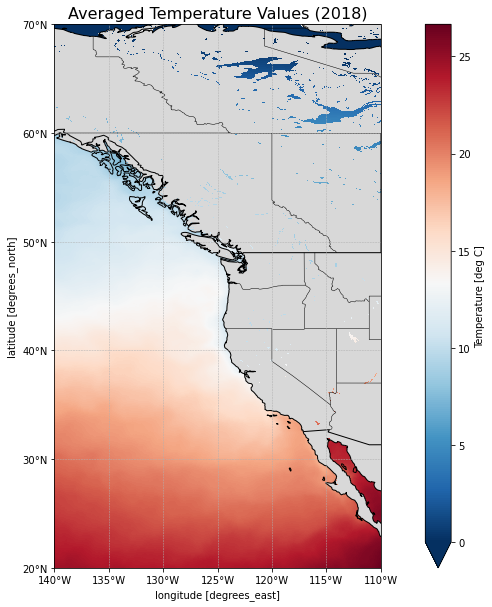

In [11]:
#define latitude and longitude boundaries
latr = [min(sst.analysed_sst['lat']), max(sst.analysed_sst['lat'])] 
lonr = [max(sst.analysed_sst['lon']), min(sst.analysed_sst['lon'])] 

# Select a region of our data, giving it a margin
margin = 0
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='50m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS, color = 'black')
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,5)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,10)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

# Plot track data, color by temperature
sst.analysed_sst.plot(transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'Temperature [deg C]'}, vmin = 0, cmap = "RdBu_r")
plt.title('Averaged Temperature Values (2018)', fontdict = {'fontsize' : 16})
plt.show()

***

## Switching to the Salinity Data from the Soil Moisture Active Passive (SMAP) observatory through JPL

For this exercise we'll be use the level 3 collocated salinity data. You can access the data through a direct S3 access through Amazon Web Services (AWS) of selecting the granule data in the Earth Explorer app. The data is averaged by 8 day segments. In this exercise instead of gathering the data through the direct S3 access, you have been provided a single file of the eight day averaged data. 

[JPL SMAP Sea Surface Salnity](https://podaac.jpl.nasa.gov/dataset/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5)

In [6]:
sss = xr.open_dataset('data/RSS_smap_SSS_L3_8day_running_2018_006_FNL_v04.0.nc4') 
sss.close()
sss.sss_smap

<xarray.DataArray 'sss_smap' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    long_name:      SMAP sea surface salinity smoothed to approx 70km resolution
    standard_name:  sea_surface_salinity
    units:          1e-3
    valid_min:      0.0
    valid_max:      45.0
    origname:       sss_smap
    fullnamepath:   /sss_smap

Let's us look at the map of the whole world.

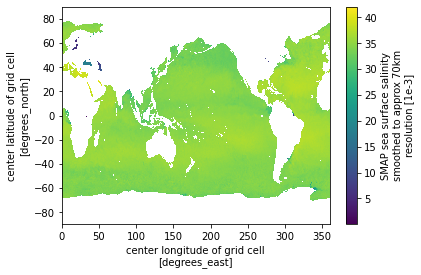

In [7]:
sss.sss_smap.plot()

Now let's zoom in to a the West Coast of the US.

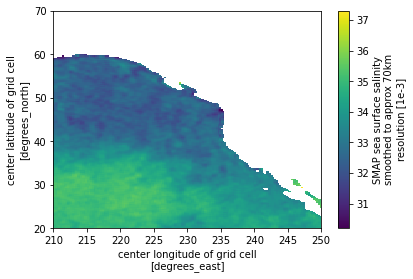

In [8]:
mask_lon = (sss.lon >= 210) & (sss.lon <= 250)
mask_lat = (sss.lat >= 20) & (sss.lat <= 70)

sss_zoomed = sss.where(mask_lon & mask_lat, drop=True)
sss_zoomed.sss_smap.plot()

### Compare SST and SSS Data

Lets make two figures that show the spatial differences between the temperature and salinity. Notice 1) the differences in spatial resoluation (the size of the pixels for each data point), and 2) the distance from shore that temperature and salinity are measured to. 

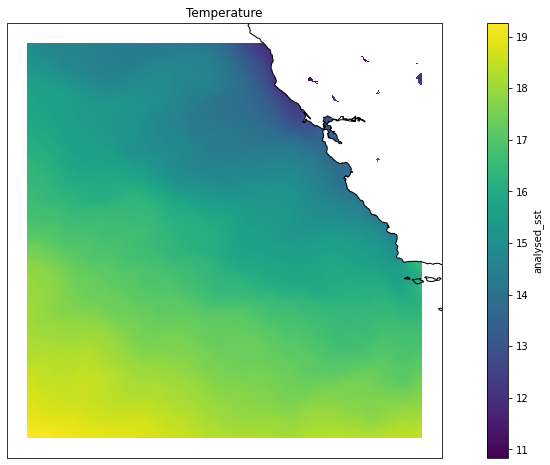

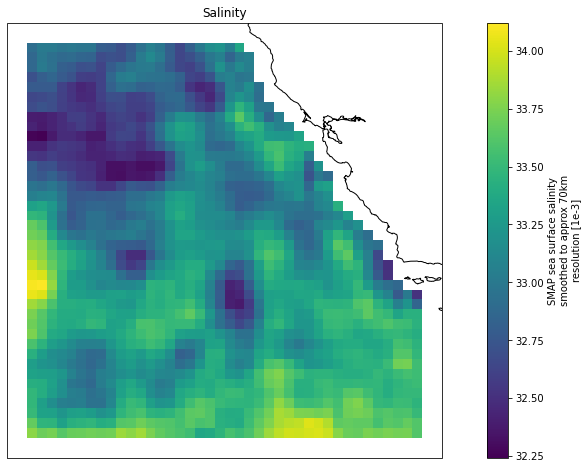

In [36]:
###Temperature Map

sst_mask_lon = (sst.lon >= -130) & (sst.lon <= -120)
sst_mask_lat = (sst.lat >= 30) & (sst.lat <= 40)

plt.figure(figsize=(16,8), dpi = 72)
sst_compare = sst.where(sst_mask_lon & sst_mask_lat, drop=True)

p = sst_compare.analysed_sst.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree())
plt.title("Temperature")
p.axes.coastlines()

###Salinity Map

sss_mask_lon = (sss.lon >= 230) & (sss.lon <= 240)
sss_mask_lat = (sss.lat >= 30) & (sss.lat <= 40)

plt.figure(figsize=(16,8), dpi = 72)
sss_compare = sss.where(sss_mask_lon & sss_mask_lat, drop=True)
q = sss_compare.sss_smap.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree())
plt.title("Salinity")
q.axes.coastlines()


## Interpolating the Salinity Data

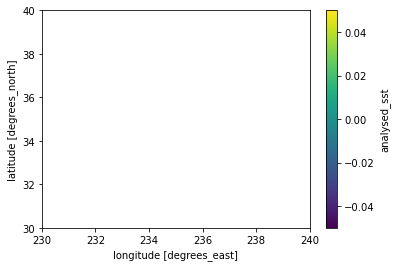

In [77]:
sst_interpolated = sst_compare.analysed_sst.interp_like(sss_compare.sss_smap)
sst_interpolated

In [71]:
sss_compare

<xarray.Dataset>
Dimensions:               (lat: 40, lon: 40, time: 1)
Coordinates:
  * lat                   (lat) float32 30.12 30.38 30.62 ... 39.38 39.62 39.88
  * lon                   (lon) float32 230.1 230.4 230.6 ... 239.4 239.6 239.9
  * time                  (time) datetime64[ns] 2018-01-06T12:00:00
Data variables:
    sss_smap              (lat, lon) float32 33.8 33.7 33.73 ... nan nan nan
    nobs_40km             (lat, lon) float64 14.0 12.0 10.0 12.0 ... nan nan nan
    gice                  (lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    surtep                (lat, lon) float32 292.0 291.9 291.6 ... nan nan nan
    gland                 (lat, lon) float32 0.0002437 0.000255 ... 0.982 0.9778
    nobs                  (lat, lon) float64 9.0 9.0 9.0 9.0 ... nan nan nan nan
    sss_smap_40km         (lat, lon) float32 33.93 33.95 33.46 ... nan nan nan
    sss_ref               (lat, lon) float32 34.04 34.0 34.0 ... nan nan nan
    fland                 (lat, lon) float32 1.263e-08 1.263e-08 ... 0.9927
    sss_smap_uncertainty  (lat, lon) float32 0.2668 0.2688 0.2718 ... nan nan
Attributes: (12/59)
    Conventions:                                    CF-1.6, ACDD-1.3
    standard_name_vocabulary:                       CF Standard Name Table v27
    title:                                          SMAP ocean surface salinity
    version:                                        V4.0 Validated Release
    processing_level:                               L3
    resolution:                                     Spatial resolution: appro...
    ...                                             ...
    Source_of_SMAP_SSS:                             Meissner, T., F. Wentz, A...
    Source_of__ancillary_reference_SSS_from_HYCOM:  Hybrid Coordinate Ocean M...
    Source_of_ancillary_SST:                        Canada Meteorological Cen...
    Source_of_ancillary_AMSR2_sea_ice_mask:         RSS AMSR2 sea-ice mask. W...
    Source_of_ancillary_land_mask:                  1 km land/water mask from...
    history_json:                                   [{"$schema":"https:\/\/ha...

## Resources

For the cloud and data in the cloud, see resources listed in Chapter 5.

### Resources specifically for this chapter:

- [MUR SST Data](https://registry.opendata.aws/mur/). SST data in the cloud, with references the official datta website, examples and other resources.

- [Pangeo OSM2020 Tutorial](https://github.com/pangeo-gallery/osm2020tutorial). This is a very good tutorial for ocean application and cloud computing. Plenty of examples. Many of the commands here are from this tutorial.

### About MHW

- [Marine heatwaves](http://www.marineheatwaves.org/all-about-mhws.html). A good place to begin to get info about the subject.

- [Marine heatwaves code](https://github.com/ecjoliver/marineHeatWaves). Marine heatwaves code from E. Oliver.

### If you want to learn more:

- [Methods for accessing a AWS bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/access-bucket-intro.html). Bucket is the name of the cloud storage object. S3 stands for Amazon's Simple Storage Service.

- [hvplot site](https://hvplot.holoviz.org/index.html). Plotting tool used here.

- [zarr](https://zarr.readthedocs.io/en/stable/). Learn more about this big data storage format.